In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'LSTM Time Series Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [8]:
nr_test_sets = ['600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [9]:
r_test_sets = ['600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


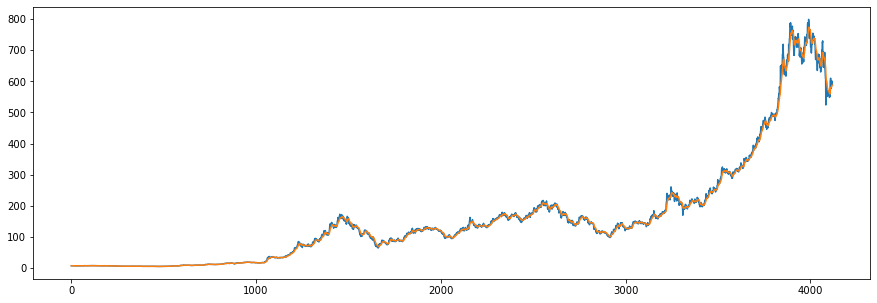

In [10]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 15, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 3738, 1.0: 183, 0.0: 185})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('600519.SS')]
    y = nr_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('600519.SS')]
    y = r_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 1s 37ms/step - loss: 0.3042 - accuracy: 0.5250 - mse: 0.4305 - weighted_accuracy: 0.3198 - weighted_mse: 0.5168 - val_loss: 0.3008 - val_accuracy: 0.0426 - val_mse: 0.3515 - val_weighted_accuracy: 0.0426 - val_weighted_mse: 0.3515
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.2189 - accuracy: 0.4190 - mse: 0.6850 - weighted_accuracy: 0.4296 - weighted_mse: 0.6941 - val_loss: 0.2939 - val_accuracy: 0.0450 - val_mse: 0.3760 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3760
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1929 - accuracy: 0.3161 - mse: 0.9368 - weighted_accuracy: 0.4802 - weighted_mse: 0.9091 - val_loss: 0.2845 - val_accuracy: 0.0450 - val_mse: 0.4108 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4108
Epoch 4/20
26/26 [==============================] - 0s 8m

7/7 [==============================] - 0s 3ms/step - loss: 0.1781 - accuracy: 0.4952 - mse: 1.2355 - weighted_accuracy: 0.4952 - weighted_mse: 1.2355
Test loss: 0.178114116191864
Test accuracy: 0.4951923191547394


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 0
actual sells but predicted hold: 5
actual holds but predicted buy: 72
actual holds but predicted sell: 22
actual predicted holds: 95
Percentage buys correct: 9.411764705882353%
Percentage sells correct: 0.0%
Percentage holds correct: 94.05940594059406%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 43.529411764705884%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 87.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously b

Epoch 1/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1220 - accuracy: 0.4644 - mse: 1.9537 - weighted_accuracy: 0.7544 - weighted_mse: 1.8811 - val_loss: 0.1713 - val_accuracy: 0.5073 - val_mse: 1.9224 - val_weighted_accuracy: 0.5073 - val_weighted_mse: 1.9224
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1213 - accuracy: 0.5201 - mse: 1.9476 - weighted_accuracy: 0.7663 - weighted_mse: 1.9052 - val_loss: 0.1766 - val_accuracy: 0.4805 - val_mse: 2.0585 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 2.0585
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1206 - accuracy: 0.4933 - mse: 1.9999 - weighted_accuracy: 0.7649 - weighted_mse: 1.9366 - val_loss: 0.1886 - val_accuracy: 0.4453 - val_mse: 1.9845 - val_weighted_accuracy: 0.4453 - val_weighted_mse: 1.9845
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1196 - accuracy: 0.5131 - mse: 1.9961 - weighted_accuracy: 0.7743 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.2007 - accuracy: 0.3846 - mse: 2.5517 - weighted_accuracy: 0.3846 - weighted_mse: 2.5517
Test loss: 0.20066651701927185
Test accuracy: 0.38461539149284363


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 41
actual holds but predicted sell: 79
actual predicted holds: 69
Percentage buys correct: 10.638297872340425%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 92.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 63.829787234042556%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 85.33333333333333%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase 

Epoch 13/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.6961 - mse: 2.6772 - weighted_accuracy: 0.8586 - weighted_mse: 2.7118 - val_loss: 0.1927 - val_accuracy: 0.5268 - val_mse: 2.8062 - val_weighted_accuracy: 0.5268 - val_weighted_mse: 2.8062
Epoch 14/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0925 - accuracy: 0.6492 - mse: 2.7485 - weighted_accuracy: 0.8586 - weighted_mse: 2.7489 - val_loss: 0.1838 - val_accuracy: 0.5426 - val_mse: 2.8196 - val_weighted_accuracy: 0.5426 - val_weighted_mse: 2.8196
Epoch 15/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0902 - accuracy: 0.6909 - mse: 2.7406 - weighted_accuracy: 0.8675 - weighted_mse: 2.7568 - val_loss: 0.1695 - val_accuracy: 0.5693 - val_mse: 2.7985 - val_weighted_accuracy: 0.5693 - val_weighted_mse: 2.7985
Epoch 16/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0886 - accuracy: 0.7010 - mse: 2.7620 - weighted_accuracy: 0.8776 - weighted

Epoch 1/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.6864 - mse: 2.9337 - weighted_accuracy: 0.8788 - weighted_mse: 2.9664 - val_loss: 0.1595 - val_accuracy: 0.6399 - val_mse: 2.9405 - val_weighted_accuracy: 0.6399 - val_weighted_mse: 2.9405
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.7418 - mse: 2.9934 - weighted_accuracy: 0.8840 - weighted_mse: 3.0429 - val_loss: 0.1687 - val_accuracy: 0.6217 - val_mse: 3.1614 - val_weighted_accuracy: 0.6217 - val_weighted_mse: 3.1614
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0830 - accuracy: 0.7119 - mse: 3.0262 - weighted_accuracy: 0.8881 - weighted_mse: 3.0623 - val_loss: 0.1685 - val_accuracy: 0.6192 - val_mse: 3.0777 - val_weighted_accuracy: 0.6192 - val_weighted_mse: 3.0777
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0825 - accuracy: 0.7266 - mse: 3.0421 - weighted_accuracy: 0.8870 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1814 - accuracy: 0.5433 - mse: 3.8758 - weighted_accuracy: 0.5433 - weighted_mse: 3.8758
Test loss: 0.1814221292734146
Test accuracy: 0.5432692170143127


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 30
actual holds but predicted sell: 56
actual predicted holds: 103
Percentage buys correct: 13.88888888888889%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 93.63636363636364%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 72.22222222222223%
Percentage high sells correct: 49.18032786885246%
Percentage mid holds correct: 89.0909090909091%


Capital: 100
Share price: $0.08015445401996278
Shares owned at the moment: 1244
Cash capital at the moment: $0.013650811964012632


Pric

Epoch 16/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0570 - accuracy: 0.8353 - mse: 4.5943 - weighted_accuracy: 0.9397 - weighted_mse: 4.6267 - val_loss: 0.1736 - val_accuracy: 0.6873 - val_mse: 4.7710 - val_weighted_accuracy: 0.6873 - val_weighted_mse: 4.7710
Epoch 17/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0575 - accuracy: 0.8216 - mse: 4.5579 - weighted_accuracy: 0.9325 - weighted_mse: 4.5759 - val_loss: 0.1821 - val_accuracy: 0.6642 - val_mse: 4.8122 - val_weighted_accuracy: 0.6642 - val_weighted_mse: 4.8122
Epoch 18/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0564 - accuracy: 0.8343 - mse: 4.6510 - weighted_accuracy: 0.9394 - weighted_mse: 4.6467 - val_loss: 0.1855 - val_accuracy: 0.6472 - val_mse: 4.7782 - val_weighted_accuracy: 0.6472 - val_weighted_mse: 4.7782
Epoch 19/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.8414 - mse: 4.7454 - weighted_accuracy: 0.9419 - weighted

0         678.794088  



RUNNING EPOCHS 120 - 140



Epoch 1/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.8243 - mse: 4.8172 - weighted_accuracy: 0.9357 - weighted_mse: 4.8381 - val_loss: 0.1495 - val_accuracy: 0.7530 - val_mse: 5.1174 - val_weighted_accuracy: 0.7530 - val_weighted_mse: 5.1174
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0528 - accuracy: 0.8544 - mse: 4.9598 - weighted_accuracy: 0.9446 - weighted_mse: 4.9431 - val_loss: 0.1844 - val_accuracy: 0.6715 - val_mse: 5.2005 - val_weighted_accuracy: 0.6715 - val_weighted_mse: 5.2005
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0521 - accuracy: 0.8392 - mse: 4.9579 - weighted_accuracy: 0.9411 - weighted_mse: 4.9736 - val_loss: 0.1879 - val_accuracy: 0.6727 - val_mse: 5.2150 - val_weighted_accuracy: 0.6727 - val_weighted_mse: 5.2150
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.8538 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1771 - accuracy: 0.6971 - mse: 6.2078 - weighted_accuracy: 0.6971 - weighted_mse: 6.2078
Test loss: 0.1770971119403839
Test accuracy: 0.6971153616905212


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 9
actual holds but predicted sell: 39
actual predicted holds: 141
Percentage buys correct: 10.0%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 91.55844155844156%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 100.0%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 87.58169934640523%


Capital: 100
Share price: $0.05517490179033468
Shares owned at the moment: 1807
Cash capital at the moment: $0.02477458414361422


Price increase from previously

Epoch 18/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0357 - accuracy: 0.9044 - mse: 7.4433 - weighted_accuracy: 0.9650 - weighted_mse: 7.0834 - val_loss: 0.1962 - val_accuracy: 0.7117 - val_mse: 7.7009 - val_weighted_accuracy: 0.7117 - val_weighted_mse: 7.7009
Epoch 19/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9144 - mse: 7.5623 - weighted_accuracy: 0.9687 - weighted_mse: 7.1305 - val_loss: 0.2033 - val_accuracy: 0.7311 - val_mse: 7.9149 - val_weighted_accuracy: 0.7311 - val_weighted_mse: 7.9149
Epoch 20/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9105 - mse: 7.6999 - weighted_accuracy: 0.9651 - weighted_mse: 7.3525 - val_loss: 0.2072 - val_accuracy: 0.7360 - val_mse: 8.3666 - val_weighted_accuracy: 0.7360 - val_weighted_mse: 8.3666
Validation loss: 0.20716138184070587
Validation accuracy: 0.7360097169876099


Non-Recession Test


7/7 [==============================] - 0s 3ms/step 

Epoch 1/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0277 - accuracy: 0.9220 - mse: 9.4191 - weighted_accuracy: 0.9715 - weighted_mse: 8.7799 - val_loss: 0.2038 - val_accuracy: 0.7725 - val_mse: 10.2756 - val_weighted_accuracy: 0.7725 - val_weighted_mse: 10.2756
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0271 - accuracy: 0.9370 - mse: 9.5800 - weighted_accuracy: 0.9748 - weighted_mse: 8.8739 - val_loss: 0.2269 - val_accuracy: 0.7397 - val_mse: 9.6170 - val_weighted_accuracy: 0.7397 - val_weighted_mse: 9.6170
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9309 - mse: 9.6231 - weighted_accuracy: 0.9747 - weighted_mse: 8.8886 - val_loss: 0.2225 - val_accuracy: 0.7457 - val_mse: 10.5304 - val_weighted_accuracy: 0.7457 - val_weighted_mse: 10.5304
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9357 - mse: 9.8290 - weighted_accuracy: 0.9765 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1904 - accuracy: 0.8029 - mse: 11.4202 - weighted_accuracy: 0.8029 - weighted_mse: 11.4202
Test loss: 0.19039851427078247
Test accuracy: 0.8028846383094788


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 4
actual holds but predicted sell: 19
actual predicted holds: 166
Percentage buys correct: 0.0%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 90.7103825136612%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 100.0%
Percentage high sells correct: 38.095238095238095%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.036451679384576156
Shares owned at the moment: 2735
Cash capital at the moment: $0.030494689612964976


Price increase from previo

In [17]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.495192,9.411765,0.000000,94.059406,43.529412,54.545455,87.000000,243.966933,678.794088
1,0.312500,12.280702,7.216495,94.444444,59.649123,51.041667,90.740741,239.289400,678.794088
2,0.384615,10.638298,6.976744,92.000000,63.829787,52.941176,85.333333,293.863181,678.794088
3,0.447115,12.820513,6.329114,92.222222,66.666667,51.282051,86.666667,367.588361,678.794088
4,0.543269,13.888889,8.064516,93.636364,72.222222,49.180328,89.090909,409.676577,678.794088
5,0.634615,16.666667,7.142857,93.283582,83.333333,42.857143,89.473684,1435.532481,678.794088
6,0.697115,10.000000,6.818182,91.558442,100.000000,45.454545,87.581699,182.706448,678.794088
7,0.769231,0.000000,6.896552,90.804598,100.000000,51.724138,86.705202,91.952292,678.794088
8,0.783654,0.000000,4.000000,90.502793,100.000000,44.000000,85.955056,212.204471,678.794088
9,0.802885,0.000000,4.761905,90.710383,100.000000,38.095238,85.714286,161.134354,678.794088


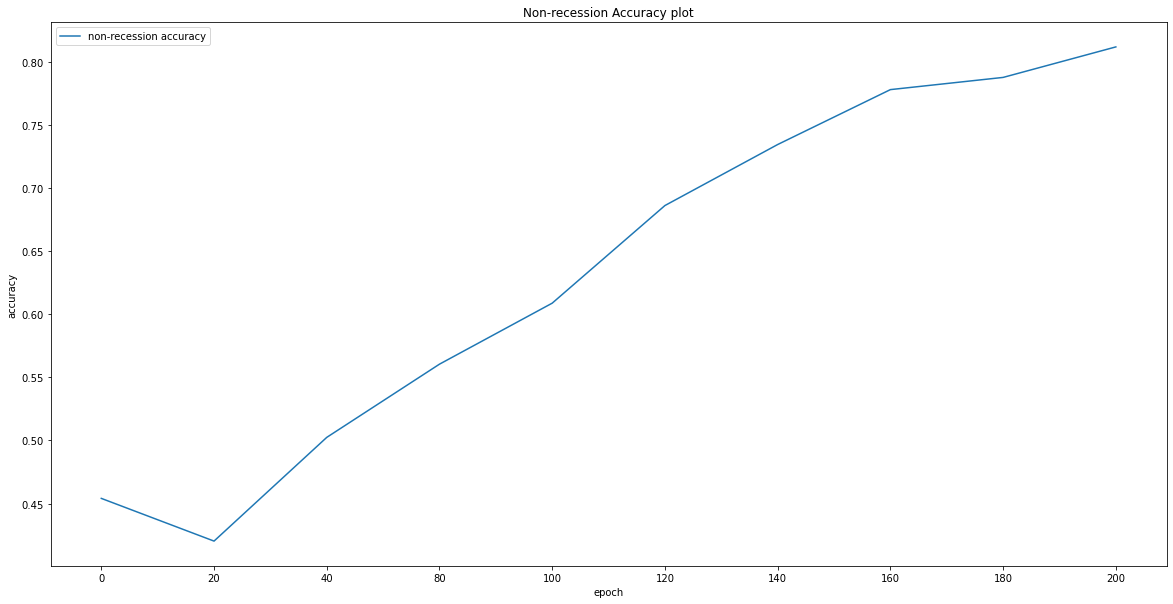

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

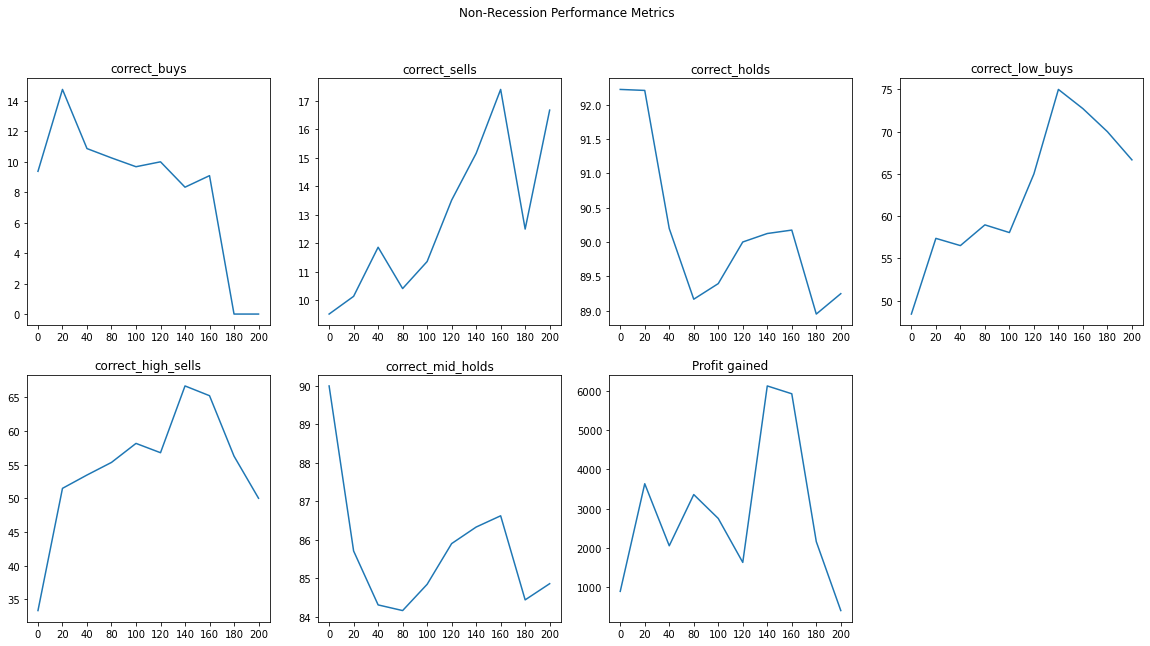

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

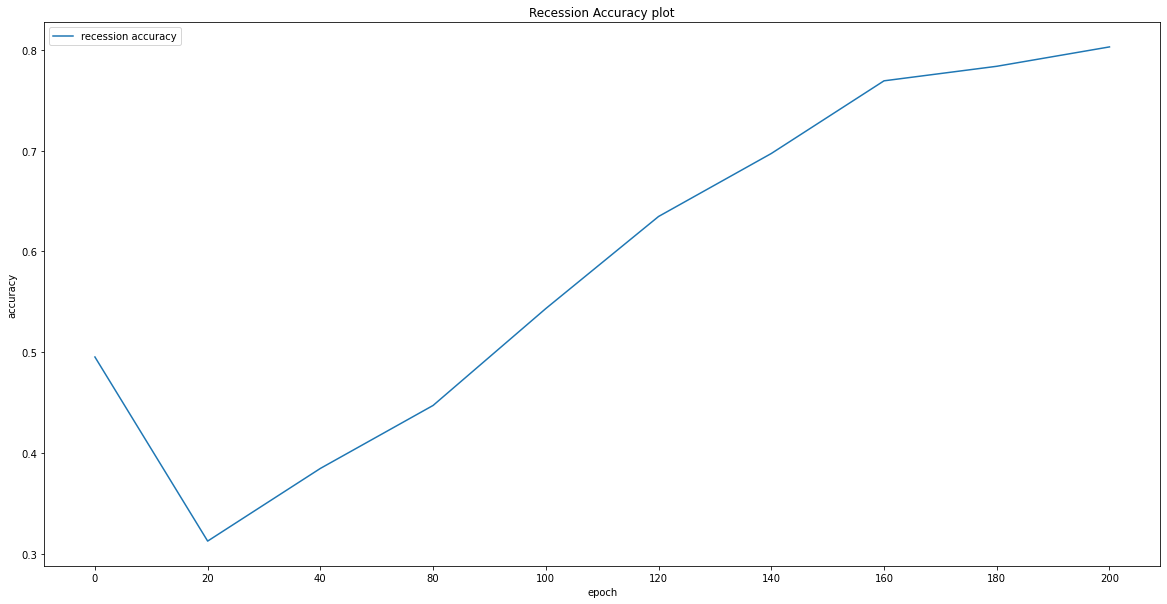

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

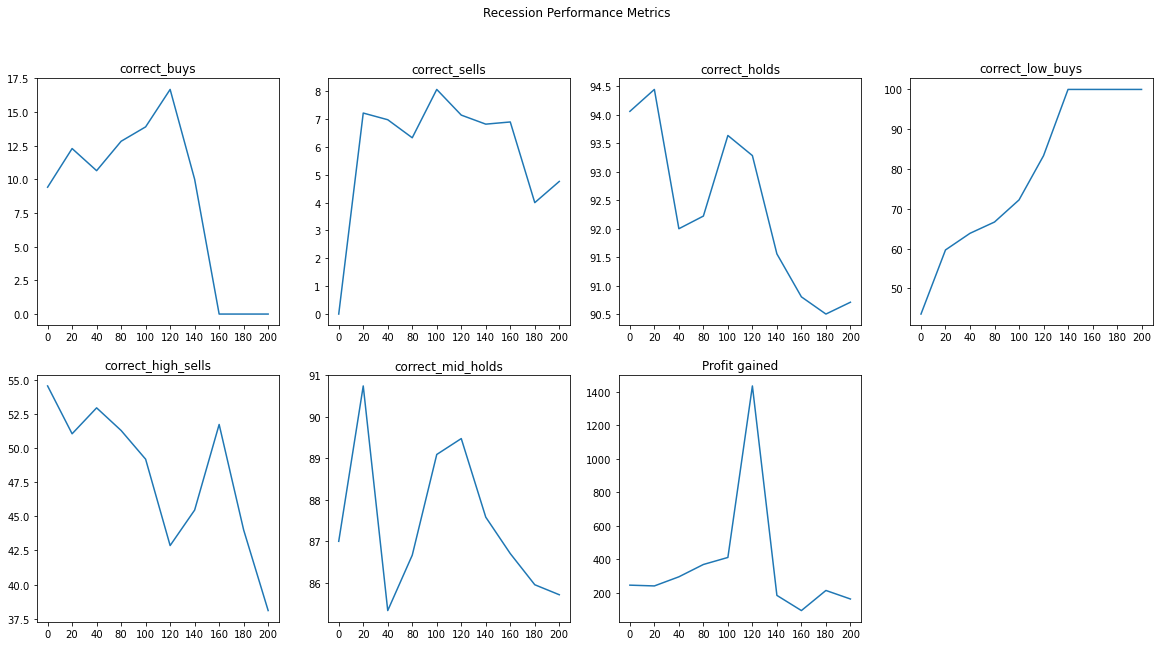

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### midea

In [22]:
nr_test_sets = ['000333.SZ']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [23]:
r_test_sets = ['000333.SZ']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


### training Data

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


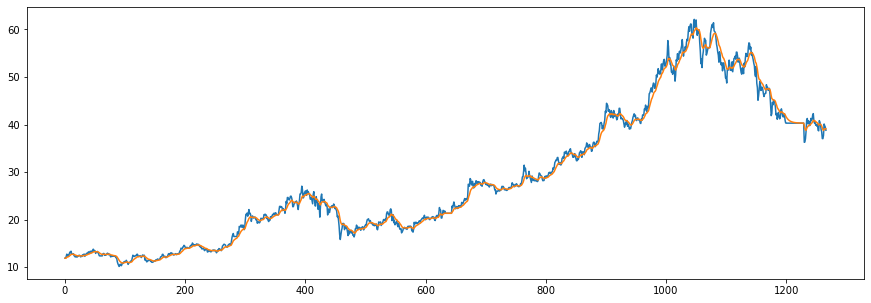

In [24]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 15, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('000333.SZ')]
    y = nr_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('000333.SZ')]
    y = r_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.9523809523809526, 1: 6.816326530612245, 2: 0.36663007683863885}



RUNNING EPOCHS 0 - 20



Epoch 1/20
8/8 [==============================] - 1s 101ms/step - loss: 0.3468 - accuracy: 0.5439 - mse: 0.3402 - weighted_accuracy: 0.2994 - weighted_mse: 0.4501 - val_loss: 0.3029 - val_accuracy: 0.0677 - val_mse: 0.3395 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 0.3395
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.2853 - accuracy: 0.5449 - mse: 0.4011 - weighted_accuracy: 0.3406 - weighted_mse: 0.4749 - val_loss: 0.3028 - val_accuracy: 0.0518 - val_mse: 0.3463 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.3463
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.2528 - accuracy: 0.5230 - mse: 0.4816 - weighted_accuracy: 0.4265 - weighted_mse: 0.5258 - val_loss: 0.3013 - val_accuracy: 0.0478 - val_mse: 0.3494 - val_weighted_accuracy: 0.0478 - val_weighted_mse: 0.3494
Epoch 4/20
8/8 [==============================] - 0s 10ms/s

8/8 [==============================] - 0s 11ms/step - loss: 0.1511 - accuracy: 0.4451 - mse: 1.2152 - weighted_accuracy: 0.7136 - weighted_mse: 1.1807 - val_loss: 0.2552 - val_accuracy: 0.0518 - val_mse: 0.5704 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.5704
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1487 - accuracy: 0.4371 - mse: 1.2232 - weighted_accuracy: 0.7236 - weighted_mse: 1.1911 - val_loss: 0.2536 - val_accuracy: 0.0518 - val_mse: 0.5888 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.5888
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1480 - accuracy: 0.4381 - mse: 1.2379 - weighted_accuracy: 0.7455 - weighted_mse: 1.1961 - val_loss: 0.2520 - val_accuracy: 0.0518 - val_mse: 0.6071 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.6071
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1463 - accuracy: 0.4441 - mse: 1.2455 - weighted_accuracy: 0.7337 - weighted_mse: 1.1977 - val_los

Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.1250 - accuracy: 0.5180 - mse: 1.3618 - weighted_accuracy: 0.7877 - weighted_mse: 1.3208 - val_loss: 0.2351 - val_accuracy: 0.0518 - val_mse: 1.0612 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 1.0612
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 0.5180 - mse: 1.3682 - weighted_accuracy: 0.7953 - weighted_mse: 1.3315 - val_loss: 0.2357 - val_accuracy: 0.0518 - val_mse: 1.0983 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 1.0983
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1227 - accuracy: 0.5070 - mse: 1.3846 - weighted_accuracy: 0.7977 - weighted_mse: 1.3375 - val_loss: 0.2361 - val_accuracy: 0.0518 - val_mse: 1.1318 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 1.1318
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1209 - accuracy: 0.5080 - mse: 1.3909 - weighted_accuracy: 0.7980 - weighted_mse: 1.344

7/7 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.1490 - mse: 1.5216 - weighted_accuracy: 0.1490 - weighted_mse: 1.5216
Test loss: 0.22765864431858063
Test accuracy: 0.14903846383094788


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 0
actual sells but predicted hold: 3
actual holds but predicted buy: 142
actual holds but predicted sell: 27
actual predicted holds: 24
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 0.0%
Percentage holds correct: 88.88888888888889%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 43.790849673202615%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 81.48148148148148%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase f

0         468.573309  



RUNNING EPOCHS 80 - 100



Epoch 1/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0855 - accuracy: 0.7295 - mse: 1.7476 - weighted_accuracy: 0.8868 - weighted_mse: 1.7733 - val_loss: 0.1566 - val_accuracy: 0.6335 - val_mse: 1.6325 - val_weighted_accuracy: 0.6335 - val_weighted_mse: 1.6325
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0848 - accuracy: 0.7275 - mse: 1.7801 - weighted_accuracy: 0.8937 - weighted_mse: 1.8168 - val_loss: 0.1707 - val_accuracy: 0.5657 - val_mse: 1.7162 - val_weighted_accuracy: 0.5657 - val_weighted_mse: 1.7162
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0833 - accuracy: 0.7056 - mse: 1.8095 - weighted_accuracy: 0.8856 - weighted_mse: 1.8375 - val_loss: 0.1632 - val_accuracy: 0.5976 - val_mse: 1.6800 - val_weighted_accuracy: 0.5976 - val_weighted_mse: 1.6800
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0817 - accuracy: 0.7226 - mse: 1.8

7/7 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.6731 - mse: 2.0237 - weighted_accuracy: 0.6731 - weighted_mse: 2.0237
Test loss: 0.14983603358268738
Test accuracy: 0.6730769276618958


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 30
actual holds but predicted sell: 26
actual predicted holds: 137
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 93.19727891156462%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.88235294117647%
Percentage high sells correct: 62.96296296296296%
Percentage mid holds correct: 84.93150684931507%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price

Epoch 13/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0461 - accuracy: 0.8762 - mse: 3.0042 - weighted_accuracy: 0.9546 - weighted_mse: 3.0054 - val_loss: 0.1628 - val_accuracy: 0.7729 - val_mse: 3.2926 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 3.2926
Epoch 14/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0438 - accuracy: 0.8782 - mse: 3.0413 - weighted_accuracy: 0.9554 - weighted_mse: 3.0160 - val_loss: 0.1585 - val_accuracy: 0.7968 - val_mse: 3.3839 - val_weighted_accuracy: 0.7968 - val_weighted_mse: 3.3839
Epoch 15/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0437 - accuracy: 0.8902 - mse: 3.0585 - weighted_accuracy: 0.9598 - weighted_mse: 3.0372 - val_loss: 0.1654 - val_accuracy: 0.7649 - val_mse: 3.4244 - val_weighted_accuracy: 0.7649 - val_weighted_mse: 3.4244
Epoch 16/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.8852 - mse: 3.1037 - weighted_accuracy: 0.9579 - weighted_mse: 3.

Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0411 - accuracy: 0.8982 - mse: 3.3765 - weighted_accuracy: 0.9627 - weighted_mse: 3.3498 - val_loss: 0.1700 - val_accuracy: 0.7649 - val_mse: 3.7798 - val_weighted_accuracy: 0.7649 - val_weighted_mse: 3.7798
Epoch 5/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0396 - accuracy: 0.8992 - mse: 3.4336 - weighted_accuracy: 0.9630 - weighted_mse: 3.3238 - val_loss: 0.1716 - val_accuracy: 0.7849 - val_mse: 3.9347 - val_weighted_accuracy: 0.7849 - val_weighted_mse: 3.9347
Epoch 6/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9022 - mse: 3.4901 - weighted_accuracy: 0.9641 - weighted_mse: 3.4129 - val_loss: 0.1693 - val_accuracy: 0.7888 - val_mse: 3.8495 - val_weighted_accuracy: 0.7888 - val_weighted_mse: 3.8495
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.8962 - mse: 3.5255 - weighted_accuracy: 0.9619 - weighted_mse: 3.3626

Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0330 - accuracy: 0.9291 - mse: 4.1366 - weighted_accuracy: 0.9740 - weighted_mse: 3.8330 - val_loss: 0.1862 - val_accuracy: 0.7729 - val_mse: 4.3672 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 4.3672
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0371 - accuracy: 0.8872 - mse: 4.1781 - weighted_accuracy: 0.9587 - weighted_mse: 4.0019 - val_loss: 0.1950 - val_accuracy: 0.7530 - val_mse: 4.2090 - val_weighted_accuracy: 0.7530 - val_weighted_mse: 4.2090
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9042 - mse: 4.1260 - weighted_accuracy: 0.9649 - weighted_mse: 3.9557 - val_loss: 0.1777 - val_accuracy: 0.8406 - val_mse: 4.8065 - val_weighted_accuracy: 0.8406 - val_weighted_mse: 4.8065
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0330 - accuracy: 0.9172 - mse: 4.1970 - weighted_accuracy: 0.9696 - weighted_mse: 4.008

7/7 [==============================] - 0s 3ms/step - loss: 0.1847 - accuracy: 0.7308 - mse: 4.9876 - weighted_accuracy: 0.7308 - weighted_mse: 4.9876
Test loss: 0.18471573293209076
Test accuracy: 0.7307692170143127


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 23
actual holds but predicted sell: 20
actual predicted holds: 150
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 92.02453987730061%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 84.5679012345679%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.7404 - mse: 5.9109 - weighted_accuracy: 0.7404 - weighted_mse: 5.9109
Test loss: 0.1959497183561325
Test accuracy: 0.7403846383094788


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 22
actual holds but predicted sell: 19
actual predicted holds: 152
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 5.0%
Percentage holds correct: 92.12121212121212%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.52173913043478%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.7560975609756%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bou

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.033654,3.365385,0.000000,0.000000,42.028986,0.000000,0.000000,468.573309,468.573309
1,0.033654,3.365385,0.000000,0.000000,42.028986,0.000000,0.000000,468.573309,468.573309
2,0.149038,4.545455,0.000000,88.888889,43.790850,55.555556,81.481481,313.964766,468.573309
3,0.519231,7.812500,2.857143,93.577982,50.000000,65.714286,87.962963,132.618421,468.573309
4,0.673077,5.882353,3.703704,93.197279,55.882353,62.962963,84.931507,-13.174274,468.573309
5,0.740385,7.142857,5.555556,93.209877,53.571429,50.000000,85.093168,119.667949,468.573309
6,0.730769,4.000000,5.000000,92.024540,60.000000,60.000000,84.567901,118.106826,468.573309
7,0.730769,4.000000,5.000000,92.024540,56.000000,50.000000,84.567901,124.861385,468.573309
8,0.730769,4.166667,4.761905,92.024540,58.333333,52.380952,84.567901,124.861385,468.573309
9,0.740385,4.347826,5.000000,92.121212,56.521739,50.000000,84.756098,131.418667,468.573309


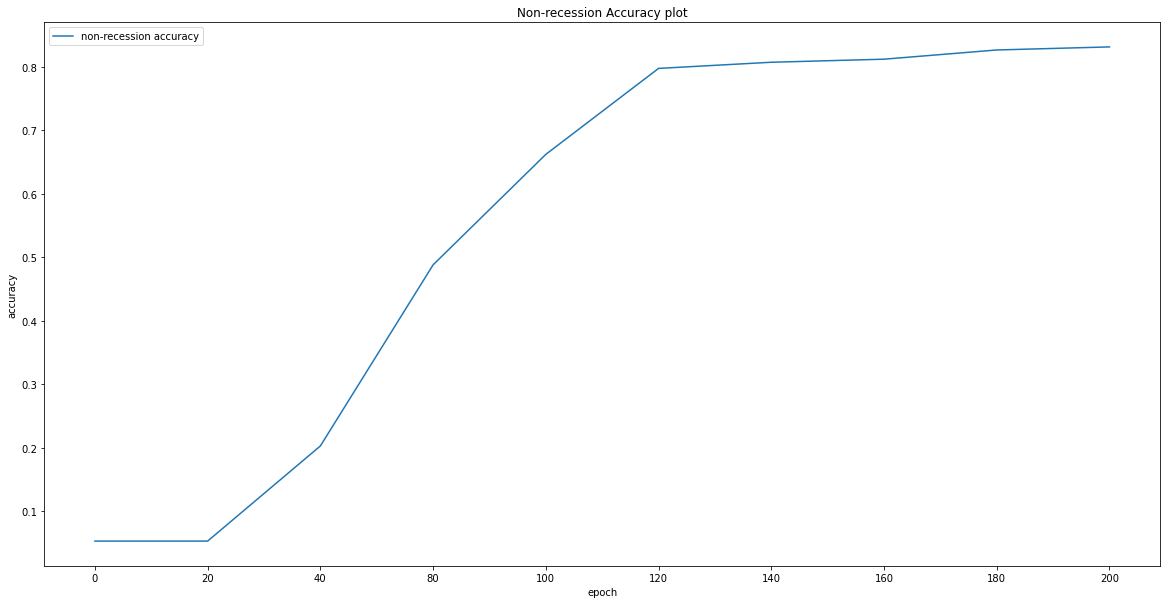

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

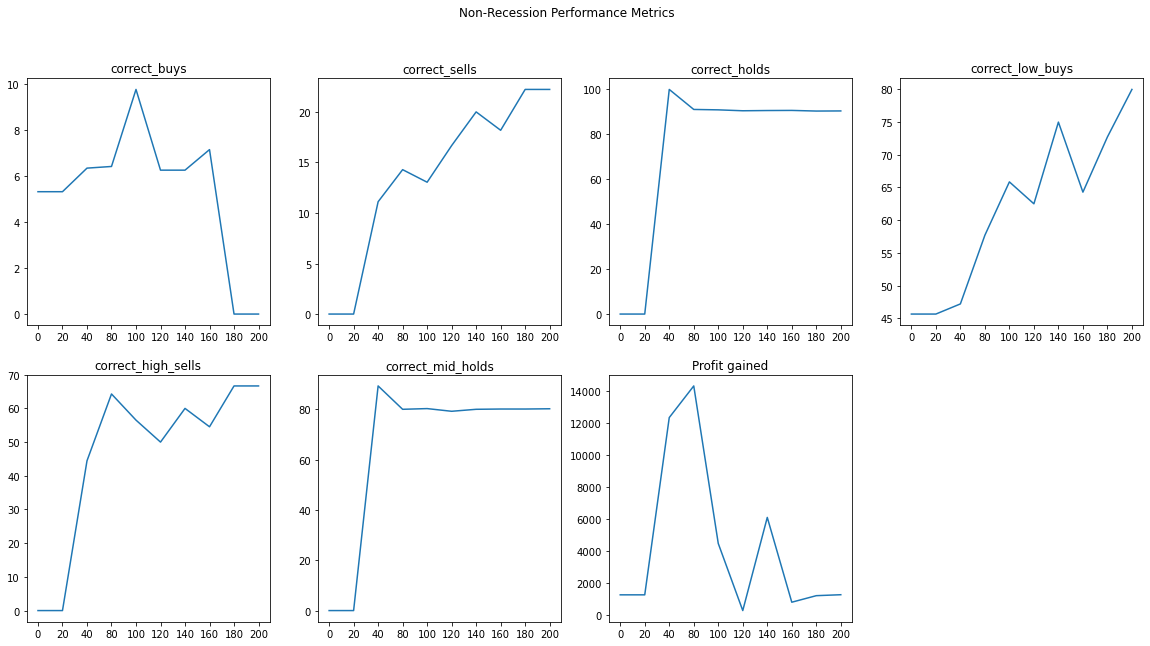

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

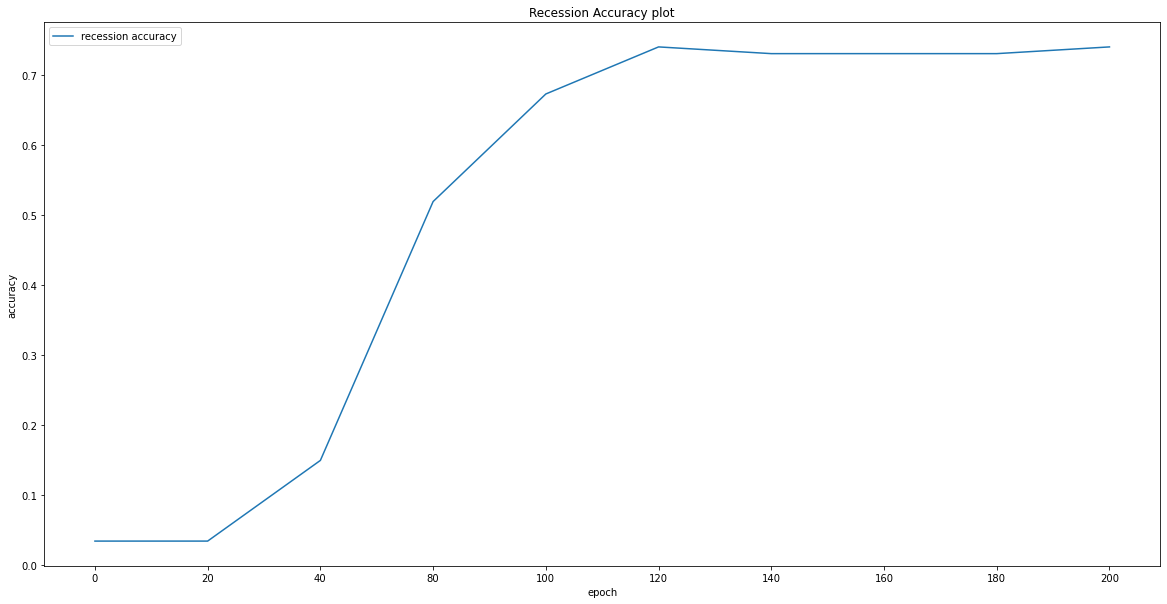

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

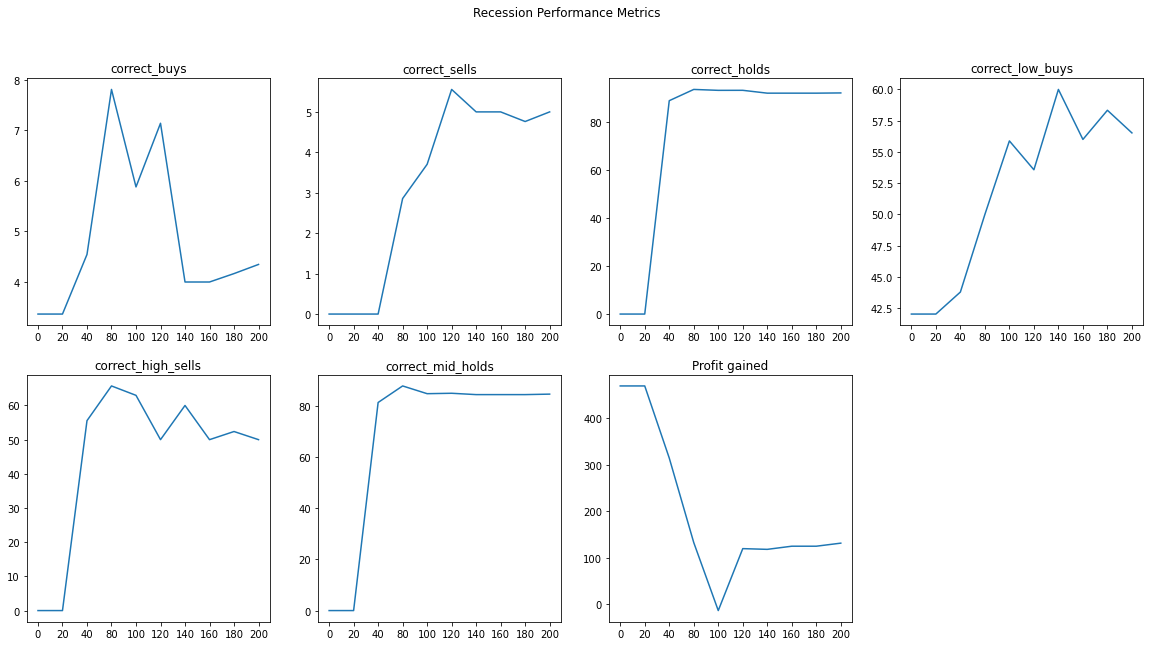

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Walmart

In [8]:
nr_test_sets = ['WMT']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [9]:
r_test_sets = ['WMT']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


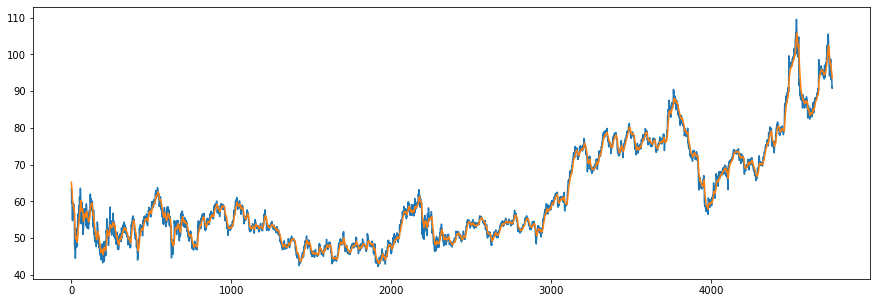

In [10]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/WMT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 15, 4)
y = labels
y = np.array(y)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [63]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('WMT')]
    y = nr_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('WMT')]
    y = r_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.148775894538606, 1: 7.3565891472868215, 2: 0.3670824871869258}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 29ms/step - loss: 0.2905 - accuracy: 0.4960 - mse: 0.4680 - weighted_accuracy: 0.3135 - weighted_mse: 0.5440 - val_loss: 0.2996 - val_accuracy: 0.0453 - val_mse: 0.3552 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3552
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2098 - accuracy: 0.3319 - mse: 0.8136 - weighted_accuracy: 0.4251 - weighted_mse: 0.7951 - val_loss: 0.2905 - val_accuracy: 0.0453 - val_mse: 0.3832 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3832
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1895 - accuracy: 0.3182 - mse: 1.0300 - weighted_accuracy: 0.4755 - weighted_mse: 1.0133 - val_loss: 0.2803 - val_accuracy: 0.0453 - val_mse: 0.4209 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4209
Epoch 4/20
30/30 [==============================] - 0s 7

7/7 [==============================] - 0s 3ms/step - loss: 0.1763 - accuracy: 0.4155 - mse: 1.2810 - weighted_accuracy: 0.4155 - weighted_mse: 1.2810
Test loss: 0.17634336650371552
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 63
actual predicted holds: 81
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.352941176470588%
Percentage holds correct: 94.18604651162791%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.76923076923077%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 87.05882352941177%


Capital: 100
Share price: $0.3296552589924817
Shares owned at the moment: 302
Cash capital at the moment: $0.1703330916772643


Price increase from

30/30 [==============================] - 0s 7ms/step - loss: 0.1317 - accuracy: 0.3880 - mse: 1.7455 - weighted_accuracy: 0.7283 - weighted_mse: 1.6549 - val_loss: 0.1823 - val_accuracy: 0.4131 - val_mse: 1.7394 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 1.7394
Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.4447 - mse: 1.7503 - weighted_accuracy: 0.7455 - weighted_mse: 1.6793 - val_loss: 0.1910 - val_accuracy: 0.3656 - val_mse: 1.7693 - val_weighted_accuracy: 0.3656 - val_weighted_mse: 1.7693
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.4618 - mse: 1.7706 - weighted_accuracy: 0.7538 - weighted_mse: 1.7046 - val_loss: 0.1933 - val_accuracy: 0.3593 - val_mse: 1.8800 - val_weighted_accuracy: 0.3593 - val_weighted_mse: 1.8800
Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1283 - accuracy: 0.4681 - mse: 1.7618 - weighted_accuracy: 0.7579 - weighted_mse: 1.6832

Epoch 1/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1204 - accuracy: 0.5021 - mse: 1.9391 - weighted_accuracy: 0.7774 - weighted_mse: 1.8850 - val_loss: 0.1974 - val_accuracy: 0.3583 - val_mse: 2.0055 - val_weighted_accuracy: 0.3583 - val_weighted_mse: 2.0055
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.4942 - mse: 1.9756 - weighted_accuracy: 0.7654 - weighted_mse: 1.9121 - val_loss: 0.1706 - val_accuracy: 0.5258 - val_mse: 1.9280 - val_weighted_accuracy: 0.5258 - val_weighted_mse: 1.9280
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1186 - accuracy: 0.5350 - mse: 1.9623 - weighted_accuracy: 0.7859 - weighted_mse: 1.9097 - val_loss: 0.1847 - val_accuracy: 0.4352 - val_mse: 2.0200 - val_weighted_accuracy: 0.4352 - val_weighted_mse: 2.0200
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1186 - accuracy: 0.5382 - mse: 2.0030 - weighted_accuracy: 0.7891 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1446 - accuracy: 0.6210 - mse: 2.3246 - weighted_accuracy: 0.6210 - weighted_mse: 2.3246
Test loss: 0.14462561905384064
Test accuracy: 0.621004581451416


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 34
actual holds but predicted sell: 42
actual predicted holds: 125
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 16.0%
Percentage holds correct: 94.6969696969697%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 54.0%
Percentage mid holds correct: 87.12121212121212%


Capital: 100
Share price: $0.2161960901927984
Shares owned at the moment: 461
Cash capital at the moment: $0.05951982777800424


Price increase from previously b

30/30 [==============================] - 0s 7ms/step - loss: 0.0882 - accuracy: 0.6765 - mse: 2.8852 - weighted_accuracy: 0.8668 - weighted_mse: 2.8681 - val_loss: 0.1765 - val_accuracy: 0.5838 - val_mse: 3.0246 - val_weighted_accuracy: 0.5838 - val_weighted_mse: 3.0246
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0862 - accuracy: 0.6963 - mse: 2.9583 - weighted_accuracy: 0.8759 - weighted_mse: 2.9389 - val_loss: 0.1566 - val_accuracy: 0.6554 - val_mse: 2.9863 - val_weighted_accuracy: 0.6554 - val_weighted_mse: 2.9863
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0853 - accuracy: 0.7052 - mse: 2.9690 - weighted_accuracy: 0.8791 - weighted_mse: 2.9434 - val_loss: 0.1693 - val_accuracy: 0.6048 - val_mse: 3.0741 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 3.0741
Validation loss: 0.16933749616146088
Validation accuracy: 0.6048471927642822


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.16

30/30 [==============================] - 0s 7ms/step - loss: 0.0852 - accuracy: 0.7013 - mse: 3.0577 - weighted_accuracy: 0.8777 - weighted_mse: 3.0343 - val_loss: 0.1623 - val_accuracy: 0.6481 - val_mse: 3.1383 - val_weighted_accuracy: 0.6481 - val_weighted_mse: 3.1383
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0833 - accuracy: 0.7197 - mse: 3.0393 - weighted_accuracy: 0.8808 - weighted_mse: 3.0258 - val_loss: 0.1674 - val_accuracy: 0.6080 - val_mse: 3.0451 - val_weighted_accuracy: 0.6080 - val_weighted_mse: 3.0451
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0837 - accuracy: 0.7226 - mse: 3.1215 - weighted_accuracy: 0.8819 - weighted_mse: 3.0828 - val_loss: 0.1830 - val_accuracy: 0.5817 - val_mse: 3.2755 - val_weighted_accuracy: 0.5817 - val_weighted_mse: 3.2755
Epoch 5/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0802 - accuracy: 0.7126 - mse: 3.1763 - weighted_accuracy: 0.8927 - weighted_mse: 3.1662 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1207 - accuracy: 0.7534 - mse: 3.9413 - weighted_accuracy: 0.7534 - weighted_mse: 3.9413
Test loss: 0.12067729979753494
Test accuracy: 0.7534246444702148


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 18
actual holds but predicted sell: 28
actual predicted holds: 155
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 20.0%
Percentage holds correct: 95.0920245398773%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 87.03703703703704%


Capital: 100
Share price: $0.2161960901927984
Shares owned at the moment: 461
Cash capital at the moment: $0.05951982777800424


Price increase from previously

30/30 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.8327 - mse: 4.9210 - weighted_accuracy: 0.9350 - weighted_mse: 4.6964 - val_loss: 0.1797 - val_accuracy: 0.6986 - val_mse: 5.0982 - val_weighted_accuracy: 0.6986 - val_weighted_mse: 5.0982
Validation loss: 0.1797124743461609
Validation accuracy: 0.698630154132843


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1541 - accuracy: 0.6972 - mse: 4.7755 - weighted_accuracy: 0.6972 - weighted_mse: 4.7755
Test loss: 0.1541377753019333
Test accuracy: 0.6972476840019226


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 22
actual holds but predicted sell: 34
actual predicted holds: 146
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.256410256410257%
Percentage 

30/30 [==============================] - 0s 8ms/step - loss: 0.0521 - accuracy: 0.8417 - mse: 5.4843 - weighted_accuracy: 0.9311 - weighted_mse: 5.2376 - val_loss: 0.2016 - val_accuracy: 0.6681 - val_mse: 5.7314 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 5.7314
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0521 - accuracy: 0.8459 - mse: 5.5612 - weighted_accuracy: 0.9381 - weighted_mse: 5.3041 - val_loss: 0.2005 - val_accuracy: 0.6691 - val_mse: 5.6985 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 5.6985
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0525 - accuracy: 0.8514 - mse: 5.6547 - weighted_accuracy: 0.9437 - weighted_mse: 5.3544 - val_loss: 0.2056 - val_accuracy: 0.6660 - val_mse: 5.7849 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 5.7849
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.8554 - mse: 5.7652 - weighted_accuracy: 0.9415 - weighted_mse: 5.4708

30/30 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.8675 - mse: 6.3329 - weighted_accuracy: 0.9477 - weighted_mse: 5.9392 - val_loss: 0.2053 - val_accuracy: 0.7028 - val_mse: 6.2684 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 6.2684
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0469 - accuracy: 0.8604 - mse: 6.4132 - weighted_accuracy: 0.9469 - weighted_mse: 5.9767 - val_loss: 0.2031 - val_accuracy: 0.7376 - val_mse: 7.0173 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 7.0173
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.8680 - mse: 6.4707 - weighted_accuracy: 0.9497 - weighted_mse: 6.0330 - val_loss: 0.2009 - val_accuracy: 0.7134 - val_mse: 6.5893 - val_weighted_accuracy: 0.7134 - val_weighted_mse: 6.5893
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.8757 - mse: 6.7024 - weighted_accuracy: 0.9508 - weighted_mse: 6.1981 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1233 - accuracy: 0.8721 - mse: 8.2505 - weighted_accuracy: 0.8721 - weighted_mse: 8.2505
Test loss: 0.1233331710100174
Test accuracy: 0.8721461296081543


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 7
actual holds but predicted sell: 9
actual predicted holds: 185
Percentage buys correct: 12.5%
Percentage sells correct: 35.714285714285715%
Percentage holds correct: 93.90862944162437%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 71.42857142857143%
Percentage mid holds correct: 86.73469387755102%


Capital: 100
Share price: $0.2161960901927984
Shares owned at the moment: 461
Cash capital at the moment: $0.05951982777800424


Price increase from previously bo

7/7 [==============================] - 0s 4ms/step - loss: 0.1552 - accuracy: 0.7936 - mse: 9.5054 - weighted_accuracy: 0.7936 - weighted_mse: 9.5054
Test loss: 0.15515655279159546
Test accuracy: 0.7935779690742493


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 12
actual holds but predicted sell: 21
actual predicted holds: 169
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 12.5%
Percentage holds correct: 93.37016574585635%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 38.46153846153846%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 85.55555555555556%


Capital: 100
Share price: $0.092137361945386
Shares owned at the moment: 1082
Cash capital at the moment: $0.03321965462383503


Price increase fr

Epoch 12/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0258 - accuracy: 0.9349 - mse: 10.9694 - weighted_accuracy: 0.9761 - weighted_mse: 9.6523 - val_loss: 0.2859 - val_accuracy: 0.6997 - val_mse: 10.1348 - val_weighted_accuracy: 0.6997 - val_weighted_mse: 10.1348
Epoch 13/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0258 - accuracy: 0.9399 - mse: 11.0855 - weighted_accuracy: 0.9780 - weighted_mse: 9.6569 - val_loss: 0.2712 - val_accuracy: 0.7703 - val_mse: 11.9315 - val_weighted_accuracy: 0.7703 - val_weighted_mse: 11.9315
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0255 - accuracy: 0.9386 - mse: 11.0308 - weighted_accuracy: 0.9775 - weighted_mse: 9.5970 - val_loss: 0.2675 - val_accuracy: 0.7366 - val_mse: 10.7947 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 10.7947
Epoch 15/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0241 - accuracy: 0.9391 - mse: 11.2520 - weighted_accuracy: 0.9

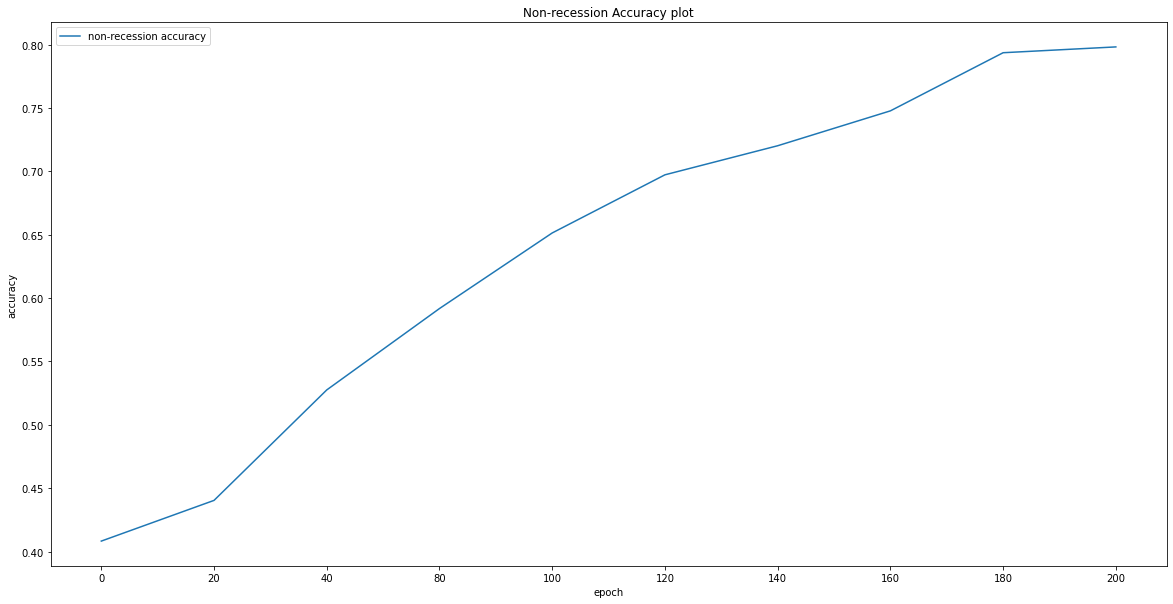

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

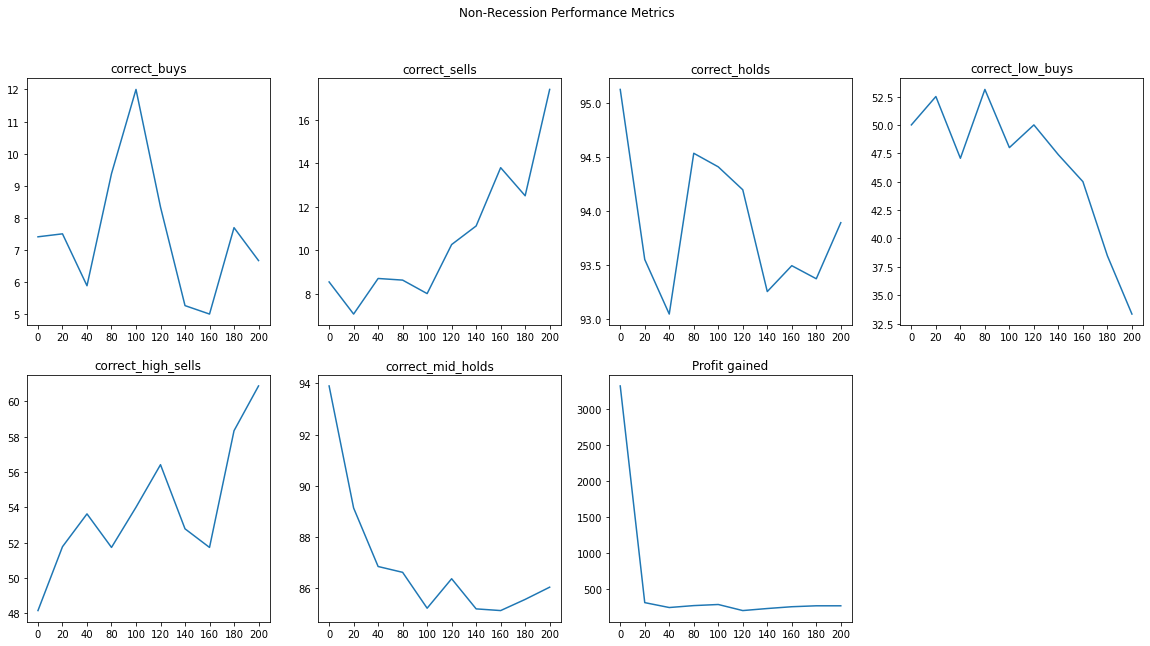

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

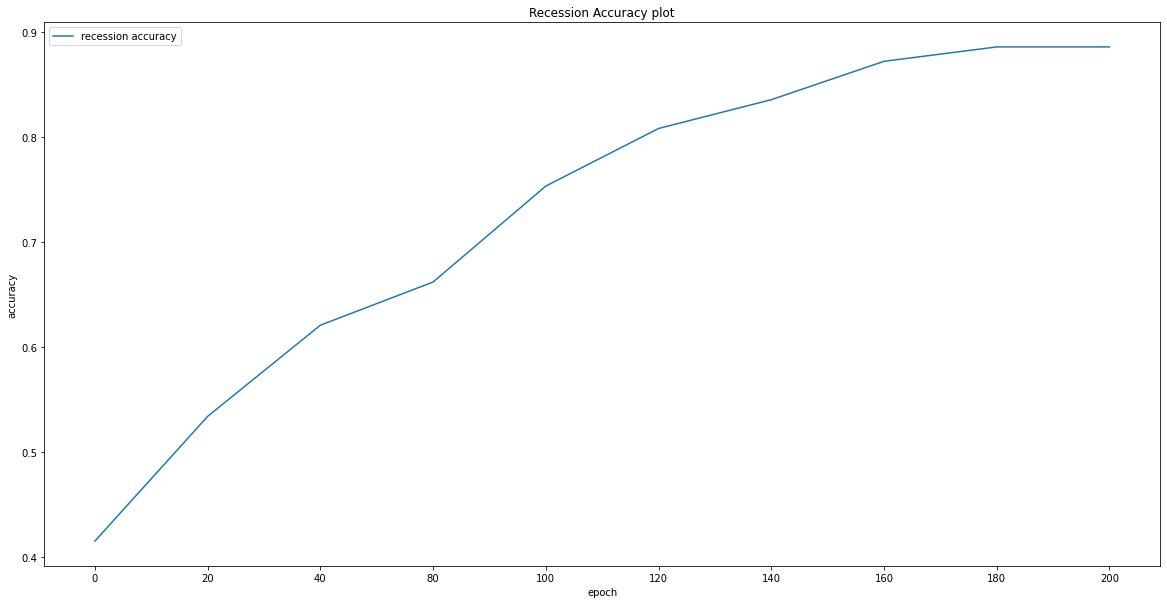

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

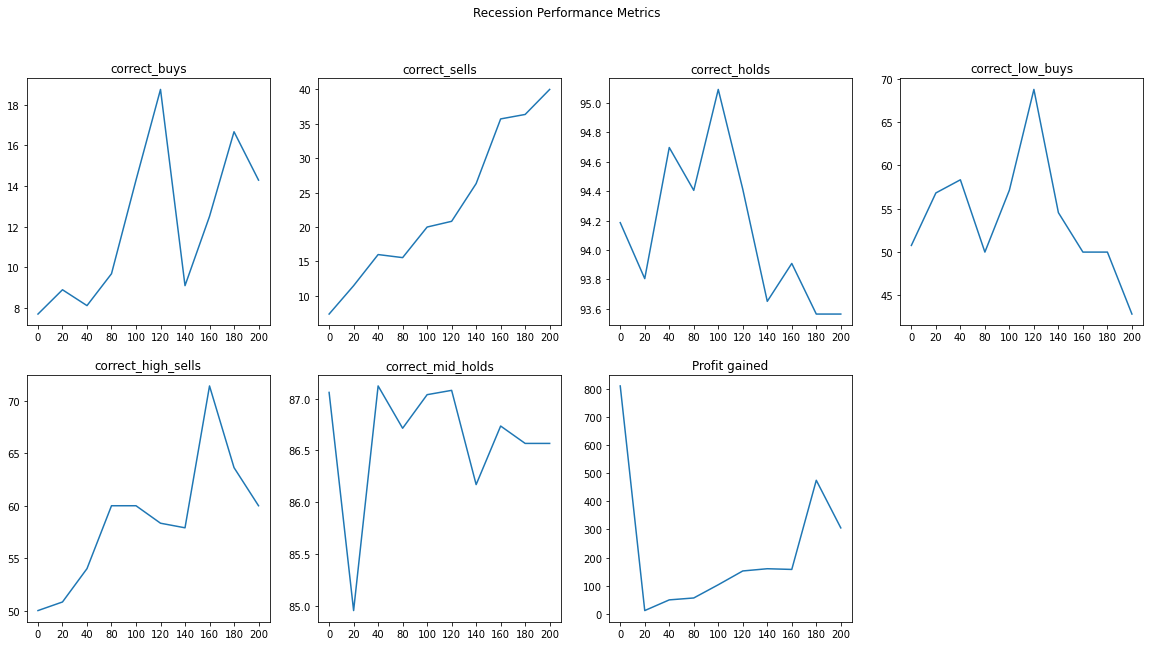

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Fresh Del Monte Produce Inc (small cap)

In [68]:
nr_test_sets = ['FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [69]:
r_test_sets = ['FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


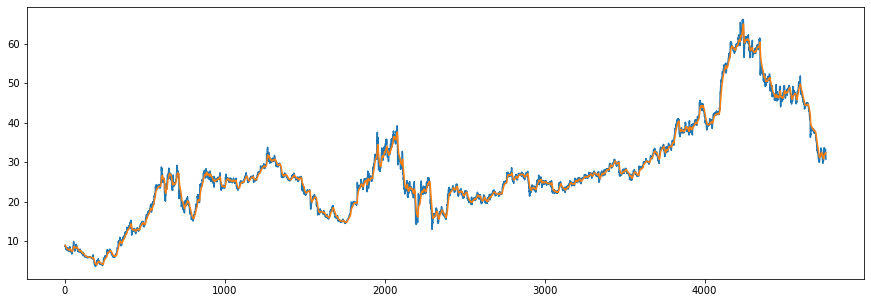

In [70]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/FDP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 15, 4)
y = labels
y = np.array(y)

In [71]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [72]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [73]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [75]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('FDP')]
    y = nr_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('FDP')]
    y = r_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.1893939393939394, 2: 0.3671890114142}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 49ms/step - loss: 0.2990 - accuracy: 0.5237 - mse: 0.4416 - weighted_accuracy: 0.2969 - weighted_mse: 0.5297 - val_loss: 0.2993 - val_accuracy: 0.0453 - val_mse: 0.3541 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3541
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2132 - accuracy: 0.3609 - mse: 0.7549 - weighted_accuracy: 0.4270 - weighted_mse: 0.7428 - val_loss: 0.2912 - val_accuracy: 0.0464 - val_mse: 0.3865 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3865
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.3135 - mse: 0.9925 - weighted_accuracy: 0.4803 - weighted_mse: 0.9643 - val_loss: 0.2804 - val_accuracy: 0.0464 - val_mse: 0.4284 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4284
Epoch 4/20
30/30 [==============================] - 0s 7ms/

7/7 [==============================] - 0s 3ms/step - loss: 0.1805 - accuracy: 0.4932 - mse: 1.2331 - weighted_accuracy: 0.4932 - weighted_mse: 1.2331
Test loss: 0.18047687411308289
Test accuracy: 0.4931506812572479


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 58
actual holds but predicted sell: 46
actual predicted holds: 95
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 9.803921568627452%
Percentage holds correct: 95.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 49.01960784313726%
Percentage mid holds correct: 89.8989898989899%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from 

30/30 [==============================] - 0s 7ms/step - loss: 0.1386 - accuracy: 0.4102 - mse: 1.5981 - weighted_accuracy: 0.6966 - weighted_mse: 1.5138 - val_loss: 0.1810 - val_accuracy: 0.4257 - val_mse: 1.5920 - val_weighted_accuracy: 0.4257 - val_weighted_mse: 1.5920
Epoch 16/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1372 - accuracy: 0.4687 - mse: 1.5659 - weighted_accuracy: 0.6930 - weighted_mse: 1.5042 - val_loss: 0.1895 - val_accuracy: 0.3888 - val_mse: 1.6221 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 1.6221
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.4434 - mse: 1.6089 - weighted_accuracy: 0.7125 - weighted_mse: 1.5389 - val_loss: 0.1800 - val_accuracy: 0.4405 - val_mse: 1.6049 - val_weighted_accuracy: 0.4405 - val_weighted_mse: 1.6049
Epoch 18/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1360 - accuracy: 0.4331 - mse: 1.6346 - weighted_accuracy: 0.7087 - weighted_mse: 1.5530




RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1337 - accuracy: 0.4789 - mse: 1.6481 - weighted_accuracy: 0.7272 - weighted_mse: 1.5899 - val_loss: 0.1873 - val_accuracy: 0.4236 - val_mse: 1.6554 - val_weighted_accuracy: 0.4236 - val_weighted_mse: 1.6554
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1329 - accuracy: 0.4528 - mse: 1.6663 - weighted_accuracy: 0.7322 - weighted_mse: 1.5967 - val_loss: 0.1746 - val_accuracy: 0.4837 - val_mse: 1.6311 - val_weighted_accuracy: 0.4837 - val_weighted_mse: 1.6311
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 0.5142 - mse: 1.6325 - weighted_accuracy: 0.7493 - weighted_mse: 1.5836 - val_loss: 0.1826 - val_accuracy: 0.4426 - val_mse: 1.6974 - val_weighted_accuracy: 0.4426 - val_weighted_mse: 1.6974
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1309 - accuracy: 0.5026 - mse: 1.6603 - weighted_ac

7/7 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.5114 - mse: 1.8229 - weighted_accuracy: 0.5114 - weighted_mse: 1.8229
Test loss: 0.17151367664337158
Test accuracy: 0.5114155411720276


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 56
actual holds but predicted sell: 40
actual predicted holds: 103
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 90.35087719298245%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.83870967741935%
Percentage high sells correct: 51.16279069767442%
Percentage mid holds correct: 84.95575221238938%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

30/30 [==============================] - 0s 7ms/step - loss: 0.1084 - accuracy: 0.6128 - mse: 2.0051 - weighted_accuracy: 0.8252 - weighted_mse: 2.0016 - val_loss: 0.1657 - val_accuracy: 0.5543 - val_mse: 2.1619 - val_weighted_accuracy: 0.5543 - val_weighted_mse: 2.1619
Epoch 10/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1085 - accuracy: 0.6512 - mse: 2.0131 - weighted_accuracy: 0.8303 - weighted_mse: 2.0213 - val_loss: 0.1814 - val_accuracy: 0.4889 - val_mse: 2.0655 - val_weighted_accuracy: 0.4889 - val_weighted_mse: 2.0655
Epoch 11/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1086 - accuracy: 0.6033 - mse: 2.0223 - weighted_accuracy: 0.8145 - weighted_mse: 2.0193 - val_loss: 0.1760 - val_accuracy: 0.5416 - val_mse: 2.1390 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 2.1390
Epoch 12/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1068 - accuracy: 0.6325 - mse: 2.0290 - weighted_accuracy: 0.8271 - weighted_mse: 2.0375

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1003 - accuracy: 0.6557 - mse: 2.2402 - weighted_accuracy: 0.8446 - weighted_mse: 2.2712 - val_loss: 0.1790 - val_accuracy: 0.5448 - val_mse: 2.2901 - val_weighted_accuracy: 0.5448 - val_weighted_mse: 2.2901
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0974 - accuracy: 0.6697 - mse: 2.2217 - weighted_accuracy: 0.8551 - weighted_mse: 2.2579 - val_loss: 0.1626 - val_accuracy: 0.6038 - val_mse: 2.2586 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 2.2586
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0968 - accuracy: 0.6928 - mse: 2.2196 - weighted_accuracy: 0.8601 - weighted_mse: 2.2694 - val_loss: 0.1757 - val_accuracy: 0.5585 - val_mse: 2.4094 - val_weighted_accuracy: 0.5585 - val_weighted_mse: 2.4094
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0962 - accuracy: 0.6955 - mse: 2.2347 - weighted_accuracy: 0.8683 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.6073 - mse: 2.6710 - weighted_accuracy: 0.6073 - weighted_mse: 2.6710
Test loss: 0.16997410356998444
Test accuracy: 0.6073059439659119


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 46
actual holds but predicted sell: 28
actual predicted holds: 125
Percentage buys correct: 9.803921568627452%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 91.24087591240875%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 50.98039215686274%
Percentage high sells correct: 67.74193548387096%
Percentage mid holds correct: 86.02941176470588%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

30/30 [==============================] - 0s 9ms/step - loss: 0.0749 - accuracy: 0.7619 - mse: 2.8833 - weighted_accuracy: 0.8963 - weighted_mse: 2.9697 - val_loss: 0.1619 - val_accuracy: 0.6754 - val_mse: 3.1204 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 3.1204
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.7690 - mse: 2.9085 - weighted_accuracy: 0.8971 - weighted_mse: 2.9926 - val_loss: 0.1662 - val_accuracy: 0.6365 - val_mse: 2.7903 - val_weighted_accuracy: 0.6365 - val_weighted_mse: 2.7903
Epoch 13/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0734 - accuracy: 0.7816 - mse: 2.9617 - weighted_accuracy: 0.9090 - weighted_mse: 3.0318 - val_loss: 0.1955 - val_accuracy: 0.5848 - val_mse: 3.2796 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 3.2796
Epoch 14/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0718 - accuracy: 0.7874 - mse: 3.0236 - weighted_accuracy: 0.9111 - weighted_mse: 3.0895

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0695 - accuracy: 0.7964 - mse: 3.3009 - weighted_accuracy: 0.9072 - weighted_mse: 3.3826 - val_loss: 0.1826 - val_accuracy: 0.6322 - val_mse: 3.4615 - val_weighted_accuracy: 0.6322 - val_weighted_mse: 3.4615
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0661 - accuracy: 0.8066 - mse: 3.2854 - weighted_accuracy: 0.9181 - weighted_mse: 3.3597 - val_loss: 0.1582 - val_accuracy: 0.6891 - val_mse: 3.3712 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 3.3712
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0657 - accuracy: 0.8119 - mse: 3.2969 - weighted_accuracy: 0.9201 - weighted_mse: 3.3822 - val_loss: 0.1698 - val_accuracy: 0.6786 - val_mse: 3.5395 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 3.5395
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0651 - accuracy: 0.8159 - mse: 3.3550 - weighted_accuracy: 0.9288 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.6986 - mse: 4.4355 - weighted_accuracy: 0.6986 - weighted_mse: 4.4355
Test loss: 0.1673506498336792
Test accuracy: 0.698630154132843


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 35
actual holds but predicted sell: 16
actual predicted holds: 148
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.79754601226993%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 58.8235294117647%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

30/30 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 0.8757 - mse: 4.7476 - weighted_accuracy: 0.9490 - weighted_mse: 4.6804 - val_loss: 0.1741 - val_accuracy: 0.7429 - val_mse: 5.3173 - val_weighted_accuracy: 0.7429 - val_weighted_mse: 5.3173
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.8675 - mse: 4.7234 - weighted_accuracy: 0.9459 - weighted_mse: 4.6625 - val_loss: 0.1570 - val_accuracy: 0.7555 - val_mse: 4.8206 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 4.8206
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0462 - accuracy: 0.8896 - mse: 4.8002 - weighted_accuracy: 0.9505 - weighted_mse: 4.7153 - val_loss: 0.1953 - val_accuracy: 0.6849 - val_mse: 4.9260 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 4.9260
Epoch 17/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0452 - accuracy: 0.8801 - mse: 4.9029 - weighted_accuracy: 0.9524 - weighted_mse: 4.8078




RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 0.8844 - mse: 5.1768 - weighted_accuracy: 0.9539 - weighted_mse: 5.0740 - val_loss: 0.1893 - val_accuracy: 0.7102 - val_mse: 5.4391 - val_weighted_accuracy: 0.7102 - val_weighted_mse: 5.4391
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0426 - accuracy: 0.8875 - mse: 5.1351 - weighted_accuracy: 0.9551 - weighted_mse: 5.0080 - val_loss: 0.1730 - val_accuracy: 0.7640 - val_mse: 5.5034 - val_weighted_accuracy: 0.7640 - val_weighted_mse: 5.5034
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.8896 - mse: 5.2178 - weighted_accuracy: 0.9540 - weighted_mse: 5.0694 - val_loss: 0.1794 - val_accuracy: 0.7408 - val_mse: 5.6075 - val_weighted_accuracy: 0.7408 - val_weighted_mse: 5.6075
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.8907 - mse: 5.3448 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.7945 - mse: 6.8981 - weighted_accuracy: 0.7945 - weighted_mse: 6.8981
Test loss: 0.16316138207912445
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 13
actual predicted holds: 169
Percentage buys correct: 19.047619047619047%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.84782608695652%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 71.42857142857143%
Percentage mid holds correct: 83.60655737704919%


Capital: 100
Share price: $0.42787290382171994
Shares owned at the moment: 233
Cash capital at the moment: $0.03145384641547366


Pr

30/30 [==============================] - 0s 9ms/step - loss: 0.0301 - accuracy: 0.9289 - mse: 7.3393 - weighted_accuracy: 0.9703 - weighted_mse: 6.7703 - val_loss: 0.2204 - val_accuracy: 0.7366 - val_mse: 7.2751 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 7.2751
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0303 - accuracy: 0.9254 - mse: 7.3100 - weighted_accuracy: 0.9690 - weighted_mse: 6.8765 - val_loss: 0.1970 - val_accuracy: 0.7987 - val_mse: 8.3065 - val_weighted_accuracy: 0.7987 - val_weighted_mse: 8.3065
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9318 - mse: 7.5288 - weighted_accuracy: 0.9749 - weighted_mse: 7.0134 - val_loss: 0.1930 - val_accuracy: 0.7893 - val_mse: 7.8157 - val_weighted_accuracy: 0.7893 - val_weighted_mse: 7.8157
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0300 - accuracy: 0.9294 - mse: 7.5016 - weighted_accuracy: 0.9723 - weighted_mse: 6.8821

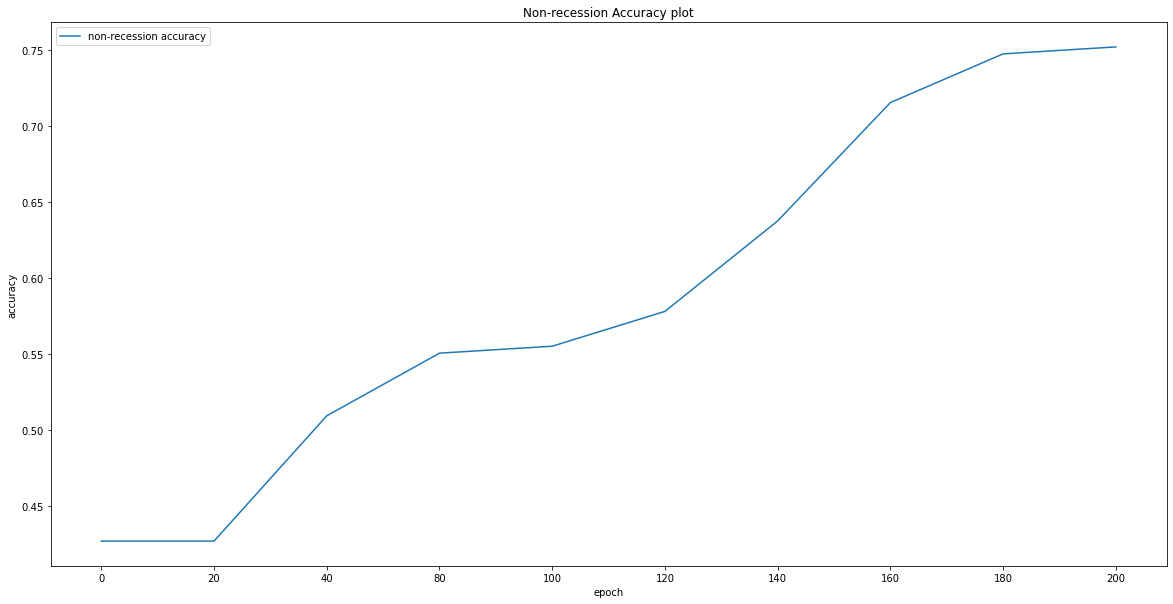

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

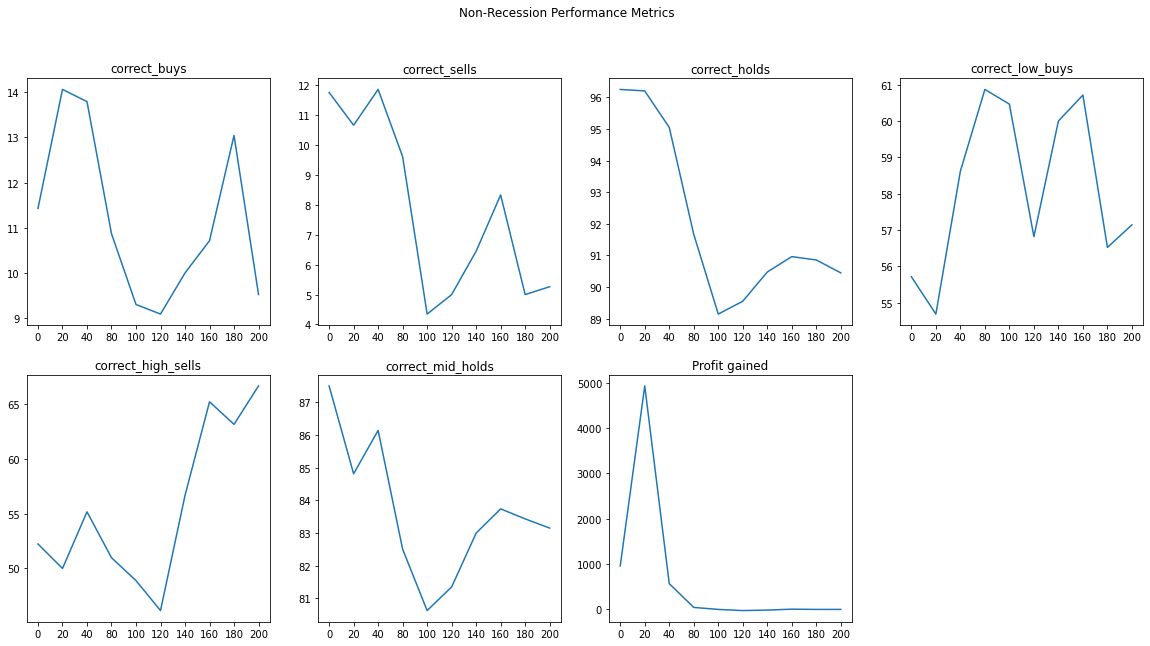

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

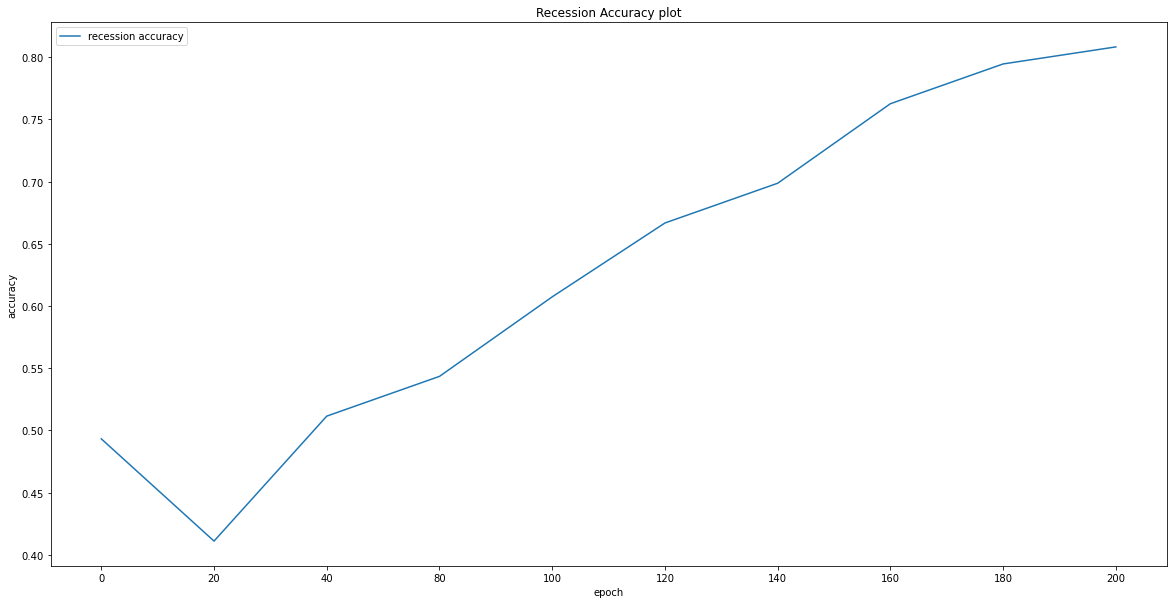

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

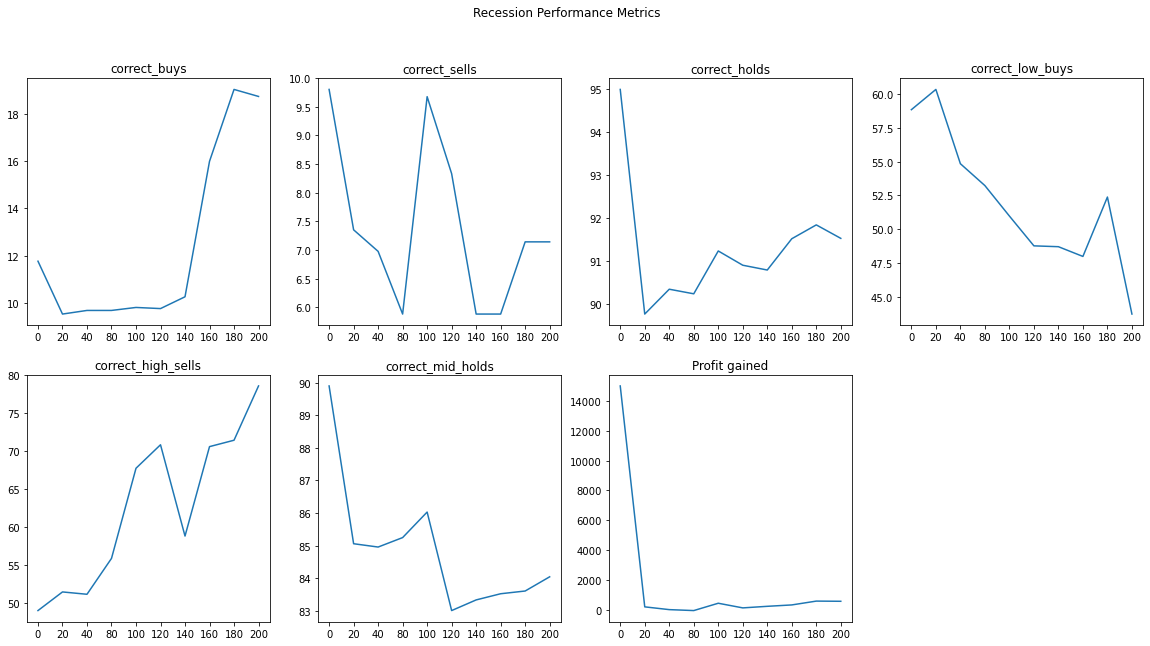

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")